In [1]:
#pip install catboost <- run first time this notebook is executed
#pip install sklearn
#pip install tabulate

In [2]:
import pandas as pd
from catboost import CatBoostRegressor
import datetime
from sklearn import preprocessing
import numpy as np
from matplotlib import pyplot as plt
import math

In [3]:
from IPython.display import HTML, display
import tabulate

In [4]:
df = pd.read_parquet('../data/forecasting_format/dataframe_forecasting_with_features.parquet')

# Forecasting, traning with all data

This notebook performs forecasting with Catboost, when trained with all data. This notebook can be seen in connection with forecasting_w_catboost_clusters and forecasting_w_catboost_single_country, as the ovjective of these notebooks are the same, however the training data differs.

As mentioned, the forecasting model is trained with all available data. This data is pre-processed using the pre_processing -> pre_processing notebook, formatted using the pre_processing -> forecasting_fromat_cases_per_day notebook and been given features by the pre_processing -> adding_features notebook. There has been selected 4 test countries that are the same for all forecasting. These were chosen at random with the condition that each of the four countries needed to be in a distinct cluster, where non of the three other test countries belonged. This had to be the case in both the k-means clusters and the hierarchical clusters. This is to ensure a fair comparison of the forecasts as possible.
<br>
<br>
Training period: 01-03-2020 -> 09-09-2020
<br>
Testinng period: 10-09-2020 -> 17-09-2020

Under testing, predictions were done with all combinations of features, this resulted in that the features 'weekday' and 'cases_tot' were disregarded, as prediction accuracy overall where effected negatively by these features. The used features are: 'Country', 'Month', 'Day', 'prev_case' where the last feature is a t-1 shift. These features are used for all forecasting predictions to ensure a fair basis of comparison as possible.

To evaluate accuracy, this and all forecasting notebooks utilize SMAPE, see paper for explanation and evaluation of this method of computing accuracy.

In [5]:
#Function used to perform prediction. Input: forecasting model, traning dataframe, test dataframe, 
#list of features, and number of predictions, default 8. Returns dataframe with same format as
#additional test_df, with an additional column with predictions.

def forecast(model, training_df, test_df, feature_list, num_predictions=8):
    start_period = 0
    end_period = num_predictions
    prediction_list = []
    
    #Generating an encoder for country feature by converting country string to int value
    if 'Country' in feature_list:
        ns_encoder = preprocessing.LabelEncoder()
        training_df['Country'] =  ns_encoder.fit_transform(training_df['Country'])
    
    #Dataframe with all features
    x_training_df = training_df[feature_list].copy()
    #Dataframe with all cases
    y_training_df = training_df['Cases'].copy().to_frame()
    model.fit(x_training_df, np.ravel(y_training_df))
    
    # Predicting on test set, while end period is not equal to end of length of test_df
    while end_period <= len(test_df):
        # Collect features from start to end and predict (10-10-2020->17-10-2020)
        features_df = test_df[feature_list][start_period:end_period].copy()
        #Generating an encoder for country feature by converting country string to int value
        if 'Country' in feature_list:
            features_df['Country'] = ns_encoder.transform(features_df['Country'])
        true_df = test_df[['Cases']][start_period:end_period].copy()
        predictions = model.predict(features_df)
       
        # Add the predicted data
        predicted_df = pd.DataFrame(predictions, columns=['predicted'])
        predicted_df.index = true_df.index.copy()        
        prediction_list.extend(predictions)
        # Move to next period
        start_period += 1
        end_period += 1
    
    df_result = test_df.assign(Predicted=prediction_list)
    return df_result

In [6]:
#Function that computes a SMAPE. Input: dataframe including true and prediction,
#true_column that specifies which column of df holds the true values and 
#pred_column that specifies which column of df hold the predicted values
def SMAPE(df,true_column,pred_column):
    true_list = df[true_column].to_numpy()
    pred_list = df[pred_column].to_numpy()
    return 1/len(true_list)*np.sum(2*np.abs(pred_list-true_list)/(np.abs(true_list)+np.abs(pred_list))*100)

In [7]:
#Function computes an additional column which sums predicted value together to form an accumulated
#prediction. Prediction for day 0 is summed to the known total cases the day before.
#Input: dataframe contanint all data on test country and dataframe including predictions produced
#by def forecast. 
def accumulated_dataframe_column(df_test_country,CB_df):
    test_start_value = df_test_country.loc[df_test_country.index == datetime.datetime(2020,9,9), 'cases_tot'].values[0]
    accumulated_list = [math.floor(test_start_value+CB_df['Predicted'][0])]
    for i in range(1,len(CB_df)):
        accumulated_list.append(math.floor(accumulated_list[i-1]+CB_df['Predicted'][i]))
    df_result = CB_df.copy()
    df_result['Accumulated_Prediction'] = accumulated_list
    return df_result

## Selecting test countries

In [8]:
Algeria_df = df[df['Country'].isin(['Algeria'])]

In [9]:
test_1_df =  Algeria_df[(Algeria_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Algeria_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [10]:
Belgium_df = df[df['Country'].isin(['Belgium'])]

In [11]:
test_2_df = Belgium_df[(Belgium_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Belgium_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [12]:
Bangladesh_df = df[df['Country'].isin(['Bangladesh'])]

In [13]:
test_3_df =  Bangladesh_df[(Bangladesh_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Bangladesh_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [14]:
Croatia_df = df[df['Country'].isin(['Croatia'])]

In [15]:
test_4_df =  Croatia_df[(Croatia_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Croatia_df.index.date <= datetime.date(2020, 9, 17))].copy()

## Test country 1, Algeria

In [16]:
training_1_df = df[(df.index.date >= datetime.date(2020, 3, 1)) & 
                    (df.index.date <= datetime.date(2020, 9, 9))].copy()

In [17]:
# Generate model
feature_list = ['Country','Month','Day','prev_case']
params= {'iterations': 5000, 'silent': True}
model = CatBoostRegressor(**params)
Algeria_CB_df = forecast(model=model, training_df=training_1_df.copy(), 
                                                             test_df=test_1_df.copy(),
                                                             feature_list=feature_list)

In [18]:
Algeria_CB_df = accumulated_dataframe_column(Algeria_df,Algeria_CB_df.copy())

In [19]:
Algeria_CB_df

,Cases,Country,cases_tot,Month,Day,Weekend,prev_case,Predicted,Accumulated_Prediction
Date,,,,,,,,,
2020-09-10,278.0,Algeria,47216.0,9,3,0.0,285.0,376.746737,47314
2020-09-11,272.0,Algeria,47488.0,9,4,0.0,278.0,268.005191,47582
2020-09-12,264.0,Algeria,47752.0,9,5,1.0,272.0,253.620123,47835
2020-09-13,255.0,Algeria,48007.0,9,6,1.0,264.0,296.012050,48131
2020-09-14,247.0,Algeria,48254.0,9,0,0.0,255.0,240.028959,48371
2020-09-15,242.0,Algeria,48496.0,9,1,0.0,247.0,488.151752,48859
2020-09-16,238.0,Algeria,48734.0,9,2,0.0,242.0,299.594726,49158
2020-09-17,232.0,Algeria,48966.0,9,3,0.0,238.0,358.328603,49516


Plot of true vs predicted when comparing cases per day and predicted cases per day:

Text(0, 0.5, 'Cases')

<Figure size 432x288 with 0 Axes>

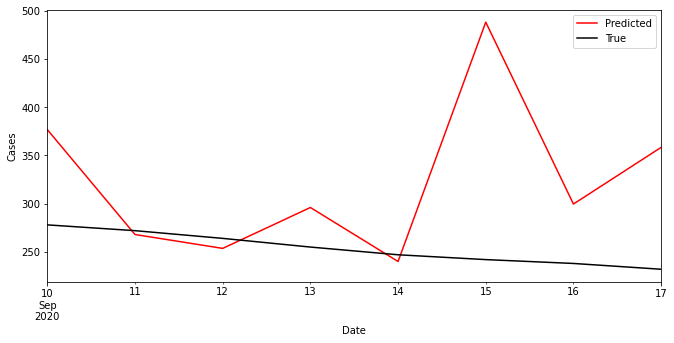

In [20]:
fig = plt.figure()
Algeria_CB_df.plot( y=['Predicted', 'Cases'], label=['Predicted','True'], color=['red','black'], figsize=(11,5))
plt.ylabel('Cases')

Plot of true vs. predicted when comparing total cases and accumulated prediction:

In [49]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

Text(0, 0.5, 'Cases')

<Figure size 1080x360 with 0 Axes>

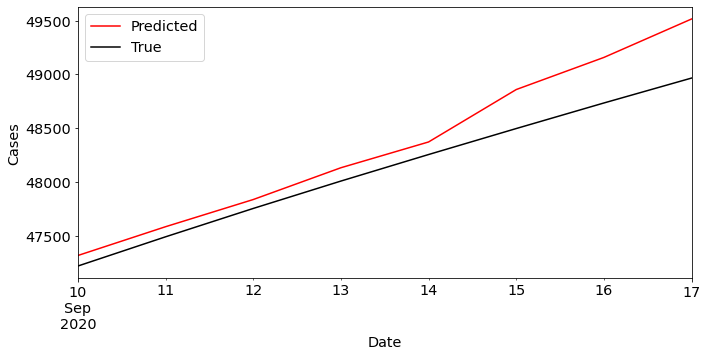

In [50]:
fig = plt.figure()
Algeria_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(11,5))
plt.ylabel('Cases')
#plt.savefig("Algeria_all_data", bbox_inches='tight')

In [22]:
round(SMAPE(Algeria_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.476

Saving result to parquet file:

In [23]:
#Algeria_CB_df.to_parquet('../results/forecasting_results/forecast_with_all_data_algeria.parquet')

## Test country 2, Belgium

In [24]:
training_2_df = df[(df.index.date >= datetime.date(2020, 3, 1)) & 
                    (df.index.date <= datetime.date(2020, 9, 9))].copy()

In [25]:
# Generate model
feature_list = ['Country','Month','Day','prev_case']
params= {'iterations': 5000, 'silent': True}
model = CatBoostRegressor(**params)
Belgium_CB_df = forecast(model=model, training_df=training_2_df.copy(), 
                                                             test_df=test_2_df.copy(),
                                                             feature_list=feature_list)

In [26]:
Belgium_CB_df = accumulated_dataframe_column(Belgium_df,Belgium_CB_df)

In [27]:
Belgium_CB_df

,Cases,Country,cases_tot,Month,Day,Weekend,prev_case,Predicted,Accumulated_Prediction
Date,,,,,,,,,
2020-09-10,1023.0,Belgium,91868.0,9,3,0.0,872.0,851.130864,91696
2020-09-11,1141.0,Belgium,93009.0,9,4,0.0,1023.0,926.812158,92622
2020-09-12,1281.0,Belgium,94290.0,9,5,1.0,1141.0,1016.409953,93638
2020-09-13,610.0,Belgium,94900.0,9,6,1.0,1281.0,1114.371946,94752
2020-09-14,296.0,Belgium,95196.0,9,0,0.0,610.0,462.201527,95214
2020-09-15,1625.0,Belgium,96821.0,9,1,0.0,296.0,450.525543,95664
2020-09-16,898.0,Belgium,97719.0,9,2,0.0,1625.0,1436.220211,97100
2020-09-17,163.0,Belgium,97882.0,9,3,0.0,898.0,875.274787,97975


Plot of true vs predicted when comparing cases per day and predicted cases per day:

Text(0, 0.5, 'Cases')

<Figure size 432x288 with 0 Axes>

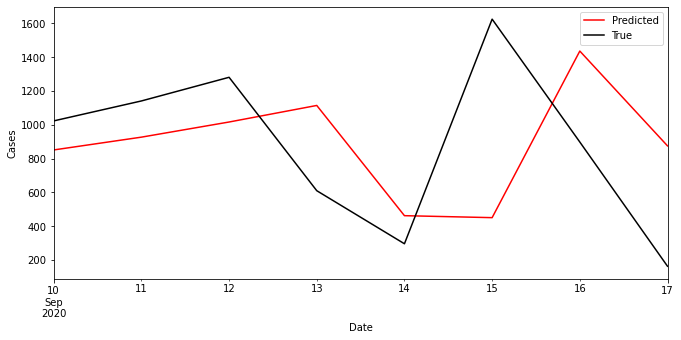

In [28]:
fig = plt.figure()
Belgium_CB_df.plot( y=['Predicted', 'Cases'], label=['Predicted','True'], color=['red','black'], figsize=(11,5))
plt.ylabel('Cases')

Plot of true vs. predicted when comparing total cases and accumulated prediction:

Text(0, 0.5, 'Cases')

<Figure size 1080x360 with 0 Axes>

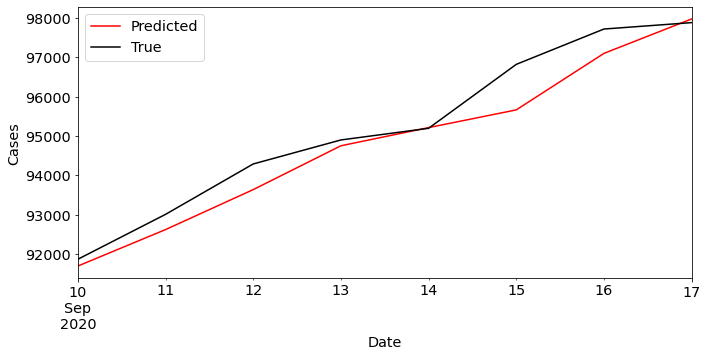

In [51]:
fig = plt.figure()
Belgium_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'],figsize=(11,5))
plt.ylabel('Cases')
#plt.savefig("Belgium_all_data", bbox_inches='tight')

In [30]:
round(SMAPE(Belgium_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.4257

Saving result to parquet file:

In [31]:
#Belgium_CB_df.to_parquet('../results/forecasting_results/forecast_with_all_data_belgium.parquet')

## Test country 3, Bangladesh

In [32]:
training_3_df = df[(df.index.date >= datetime.date(2020, 3, 1)) & 
                    (df.index.date <= datetime.date(2020, 9, 9))].copy()

In [33]:
# Generate model
feature_list = ['Country','Month','Day','prev_case']
params= {'iterations': 5000, 'silent': True}
model = CatBoostRegressor(**params)
Bangladesh_CB_df = forecast(model=model, training_df=training_3_df.copy(), 
                                                             test_df=test_3_df.copy(),
                                                             feature_list=feature_list)



In [34]:
Bangladesh_CB_df = accumulated_dataframe_column(Bangladesh_df,Bangladesh_CB_df)

In [35]:
Bangladesh_CB_df

,Cases,Country,cases_tot,Month,Day,Weekend,prev_case,Predicted,Accumulated_Prediction
Date,,,,,,,,,
2020-09-10,1827.0,Bangladesh,331078.0,9,3,0.0,1892.0,2024.688522,331275
2020-09-11,1892.0,Bangladesh,332970.0,9,4,0.0,1827.0,1847.141262,333122
2020-09-12,1792.0,Bangladesh,334762.0,9,5,1.0,1892.0,1854.202796,334976
2020-09-13,1282.0,Bangladesh,336044.0,9,6,1.0,1792.0,1556.045533,336532
2020-09-14,1476.0,Bangladesh,337520.0,9,0,0.0,1282.0,1209.783187,337741
2020-09-15,1812.0,Bangladesh,339332.0,9,1,0.0,1476.0,1641.776878,339382
2020-09-16,1724.0,Bangladesh,341056.0,9,2,0.0,1812.0,1889.519497,341271
2020-09-17,1615.0,Bangladesh,342671.0,9,3,0.0,1724.0,1789.278791,343060


Plot of true vs predicted when comparing cases per day and predicted cases per day:

Text(0, 0.5, 'Cases')

<Figure size 432x288 with 0 Axes>

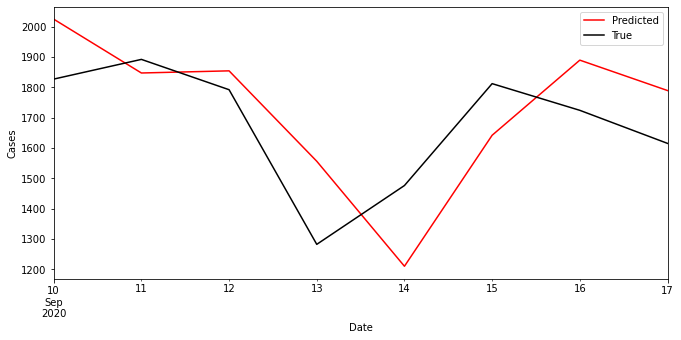

In [36]:
fig = plt.figure()
Bangladesh_CB_df.plot( y=['Predicted', 'Cases'], label=['Predicted','True'], color=['red','black'], figsize=(11,5))
plt.ylabel('Cases')

Plot of true vs. predicted when comparing total cases and accumulated prediction:

Text(0, 0.5, 'Cases')

<Figure size 1080x360 with 0 Axes>

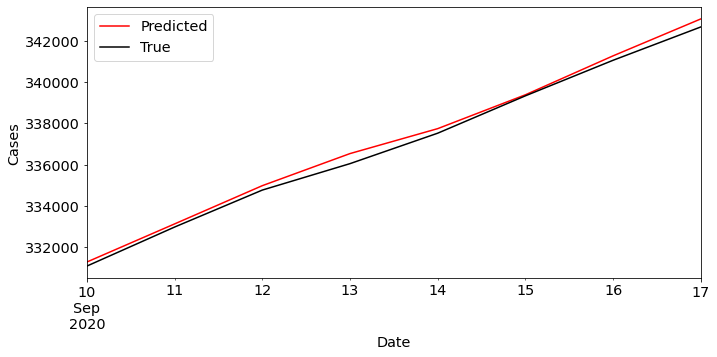

In [52]:
fig = plt.figure()
Bangladesh_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'],figsize=(11,5))
plt.ylabel('Cases')
#plt.savefig("Bangladesh_all_data", bbox_inches='tight')

In [38]:
round(SMAPE(Bangladesh_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.0714

Saving result to parquet file:

In [39]:
#Bangladesh_CB_df.to_parquet('../results/forecasting_results/forecast_with_all_data_bangladesh.parquet')

## Test country 4, Croatia

In [40]:
training_4_df = df[(df.index.date >= datetime.date(2020, 3, 1)) & 
                    (df.index.date <= datetime.date(2020, 9, 9))].copy()

In [41]:
# Generate model
feature_list = ['Country','Month','Day','prev_case']
params= {'iterations': 5000, 'silent': True}
model = CatBoostRegressor(**params)
Croatia_CB_df = forecast(model=model, training_df=training_4_df.copy(), 
                                                             test_df=test_4_df.copy(),
                                                             feature_list=feature_list)

In [42]:
Croatia_CB_df = accumulated_dataframe_column(Croatia_df,Croatia_CB_df)

In [43]:
Croatia_CB_df

,Cases,Country,cases_tot,Month,Day,Weekend,prev_case,Predicted,Accumulated_Prediction
Date,,,,,,,,,
2020-09-10,341.0,Croatia,12626.0,9,3,0.0,204.0,274.657496,12559
2020-09-11,291.0,Croatia,12917.0,9,4,0.0,341.0,406.505823,12965
2020-09-12,190.0,Croatia,13107.0,9,5,1.0,291.0,274.670818,13239
2020-09-13,261.0,Croatia,13368.0,9,6,1.0,190.0,257.417201,13496
2020-09-14,165.0,Croatia,13533.0,9,0,0.0,261.0,184.975062,13680
2020-09-15,65.0,Croatia,13598.0,9,1,0.0,165.0,269.906656,13949
2020-09-16,151.0,Croatia,13749.0,9,2,0.0,65.0,93.188012,14042
2020-09-17,280.0,Croatia,14029.0,9,3,0.0,151.0,218.233126,14260


Plot of true vs predicted when comparing cases per day and predicted cases per day:

Text(0, 0.5, 'Cases')

<Figure size 432x288 with 0 Axes>

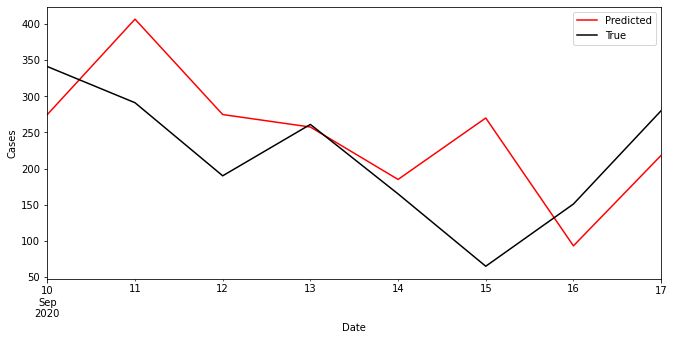

In [44]:
fig = plt.figure()
Croatia_CB_df.plot( y=['Predicted', 'Cases'], label=['Predicted','True'], color=['red','black'], figsize=(11,5))
plt.ylabel('Cases')

Plot of true vs. predicted when comparing total cases and accumulated prediction:

Text(0, 0.5, 'Cases')

<Figure size 1080x360 with 0 Axes>

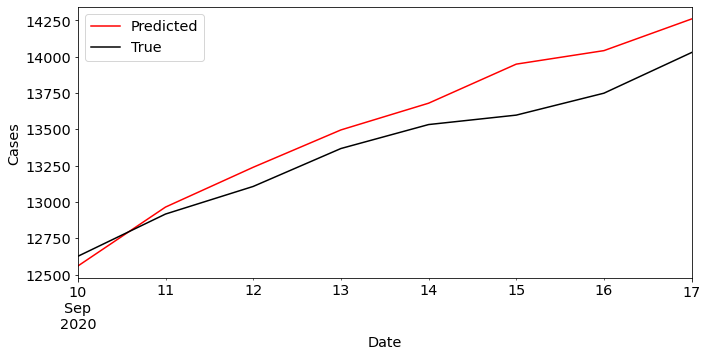

In [53]:
fig = plt.figure()
Croatia_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'],figsize=(11,5))
plt.ylabel('Cases')
#plt.savefig("Croatia_all_data", bbox_inches='tight')

In [46]:
round(SMAPE(Croatia_CB_df,'cases_tot','Accumulated_Prediction'),4)

1.2786

Saving result to parquet file:

In [47]:
#Croatia_CB_df.to_parquet('../results/forecasting_results/forecast_with_all_data_croatia.parquet')

## Summary:

In [48]:
table = [["Test Country:", "SMAPE:"],
        ["Algeria",round(SMAPE(Algeria_CB_df,'cases_tot','Accumulated_Prediction'),4)],
        ["Belgium",round(SMAPE(Belgium_CB_df,'cases_tot','Accumulated_Prediction'),4)],
        ["Bangladesh",round(SMAPE(Bangladesh_CB_df,'cases_tot','Accumulated_Prediction'),4)],
        ["Croatia",round(SMAPE(Croatia_CB_df,'cases_tot','Accumulated_Prediction'),4)],
        ["Total SMAPE:",round(SMAPE(Algeria_CB_df,'cases_tot','Accumulated_Prediction')+
                       SMAPE(Croatia_CB_df,'cases_tot','Accumulated_Prediction')+
                       SMAPE(Belgium_CB_df,'cases_tot','Accumulated_Prediction')+
                       SMAPE(Bangladesh_CB_df,'cases_tot','Accumulated_Prediction'),4)]]

display(HTML(tabulate.tabulate(table, tablefmt='html')))

Test Country:,SMAPE:
Algeria,0.476
Belgium,0.4257
Bangladesh,0.0714
Croatia,1.2786
Total SMAPE:,2.2516
